In [1]:
!ls

classifiers_mhcld.ipynb
codebook_descriptions.pickle
google_colab_t-sne_mental_health_client-level_data.ipynb
mhcld_puf_2021.csv
plots
t-sne_mental_health_client-level_data.ipynb
to_do.txt


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
NUM_POINTS = 100_000
data = pd.read_csv("mhcld_puf_2021.csv")
data = data[:NUM_POINTS]

In [4]:
# Load data the codebook descriptions
import pickle
with open('codebook_descriptions.pickle', 'rb') as handle:
    codebook_descriptions = pickle.load(handle)
assert set(list(data.columns)) == set(list(codebook_descriptions.keys()))

In [5]:
#columns to drop. reasoning in t-sne notebook.
drop_cols = ['YEAR','CASEID','SUB','MH1','MH2','MH3','SMISED','DETNLF','NUMMHS','STATEFIP','REGION','DIVISION']
data = data.drop(columns = drop_cols)

In [6]:
#disorder columns. 0/1 binary. these are dignoses for the disorders
disorder_cols = ['TRAUSTREFLG','ANXIETYFLG','ADHDFLG','CONDUCTFLG','DELIRDEMFLG','BIPOLARFLG','DEPRESSFLG','ODDFLG','PDDFLG','SCHIZOFLG','PERSONFLG','ALCSUBFLG','OTHERDISFLG']

In [7]:
#columns which require a transformation to standardize to 0-1. reasoning in t-sne notebook.
transform_cols = ['AGE','EDUC','GENDER','SPHSERVICE','CMPSERVICE','OPISERVICE','RTCSERVICE','IJSSERVICE','SAP','VETERAN ']
max_age = max(data['AGE'])
max_educ = max(data['EDUC'])
data['AGE'] = data['AGE'].apply(lambda x: x/max_age)
data['EDUC'] = data['EDUC'].apply(lambda x: 0 if x==-9 else x/max_educ)
data['GENDER'] = data['GENDER'].apply(lambda x: .5 if x==-9 else x-1)
data['SAP'] = data['SAP'].apply(lambda x: .5 if x==-9 else x-1)
data['VETERAN'] = data['VETERAN'].apply(lambda x: .5 if x==-9 else x-1)
data['SPHSERVICE'] = data['SPHSERVICE'].apply(lambda x: x-1)
data['CMPSERVICE'] = data['CMPSERVICE'].apply(lambda x: x-1)
data['OPISERVICE'] = data['OPISERVICE'].apply(lambda x: x-1)
data['RTCSERVICE'] = data['RTCSERVICE'].apply(lambda x: x-1)
data['IJSSERVICE'] = data['IJSSERVICE'].apply(lambda x: x-1)

In [8]:
#categorical columns w/ more than two categorices
#encode them with one-hot encoding
from sklearn.preprocessing import OneHotEncoder
one_hot_cols = ['ETHNIC','RACE','MARSTAT','EMPLOY','LIVARAG']
one_hot_enc=OneHotEncoder().fit(data[one_hot_cols])
one_hot_categorical_data = one_hot_enc.transform(data[one_hot_cols]).toarray()
one_hot_feature_names=list(one_hot_enc.get_feature_names_out(['ETHNIC','RACE','MARSTAT','EMPLOY','LIVARAG']))
one_hot_encoded_df = pd.DataFrame(data=one_hot_categorical_data,columns=one_hot_feature_names)
print(sum(len(item) for item in one_hot_enc.categories_))
data = data.drop(columns=one_hot_cols)
data = data.join(one_hot_encoded_df)
print(data.shape)

26
(100000, 49)


In [9]:
#create labels for the 13 disorder features
#binary encode them since they are 0/1
#take the total number of disorders present
#create unique leabel for each disorder, plus one for no disorder and one for multiple disorders
#use k-means to automatically label the clusters
from sklearn.cluster import KMeans
def get_labels(dataset, label_type='binary_encode',num_clusters=5):
    #generate labels using k-means
    if label_type == 'k-means':
        kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, random_state=0, n_init=10)
        kmeans.fit(dataset)
        return pd.DataFrame(kmeans.labels_,columns=['label'])
    labels = []
    for row in dataset[disorder_cols][:NUM_POINTS].itertuples():
        if label_type=='binary_encode':
            #binary number encoding of disorders
            encoding = sum(row[i]*2**(i-1) for i in range(1,len(row)))
            labels.append(encoding)
        #sum the total number of disorders
        num_disorders = sum(row[i] for i in range(1,len(row)))
        if label_type == 'num_disorders':
            labels.append(num_disorders)
        #unique labels for pure disorders, separate categories for multiple or no disorders
        if label_type == 'unique_disorders':
            if num_disorders == 0:
                labels.append('no_disorder')
            if num_disorders == 1:
                #get the index (string) of the column with value 1
                labels.append(disorder_cols[list(row)[1:].index(1)])
            if num_disorders > 1:
                labels.append('multi-disorder')
    return pd.DataFrame(labels,columns=['label']) 

In [10]:
kmeans_label_df = get_labels(data,label_type='k-means',num_clusters=15)

In [11]:
binary_enc_label_df = get_labels(data,label_type='binary_encode')

In [12]:
unique_disorders_label_df = get_labels(data,label_type='unique_disorders')

In [13]:
#data_labeled = label_df.merge(data, left_index=True, right_index=True)
#tsne_results_kmeans_label = kmeans_label_df.merge(data, left_index=True, right_index=True)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

In [15]:
#PERFORM RANDOM FOREST CLASSIFICATION
#may have unbalanced classes, too many in multi-disorder

In [16]:
#drop the disorder columns since we're trying to predict those
X = data.drop(columns=disorder_cols)
y = np.squeeze(unique_disorders_label_df)

In [17]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [19]:
y_pred_rf = rf.predict(X_test)

In [20]:
#zero_division warning - unbalanced classes, i.e. multi-disorder has too many elements
#17% accuracy on multi-disorder-labeled data
#36% accuracy on unique-disorder-labeled data 
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_rf, average='weighted')
print("Precision:", precision)
recall = recall_score(y_test, y_pred_rf, average='weighted')
print("Recall:", recall)

Accuracy: 0.34595
Precision: 0.3028089809454815
Recall: 0.34595


In [21]:
vis_arr = multilabel_confusion_matrix(y_test, y_pred_rf)

In [22]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("CFS_MATRIX for " + class_label)

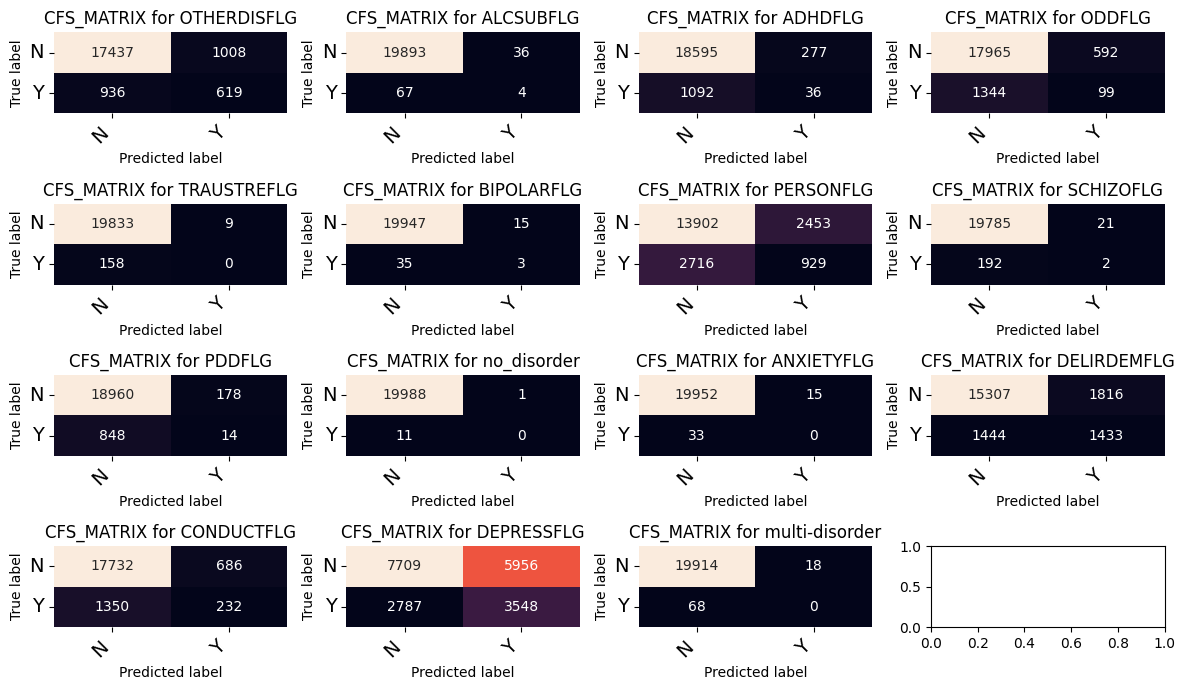

In [23]:
fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, list(set(y_test))):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
fig.savefig("./plots/confusion_matrix_mhcld_unique-disorder-label.png")
plt.show()

In [24]:
#MULTI-CLASS LOGISTIC REGRESSION

In [25]:
#drop disorder cols, we are predicting those
#use unique_disorder labels
X = data.drop(columns=disorder_cols)
#y = np.squeeze(unique_disorders_label_df)
y = np.squeeze(kmeans_label_df)
#y = np.squeeze(binary_enc_label_df)

In [26]:
# Split the data into training and test sets
#stratified k-fold didn't help much
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [27]:
#fit the logistic regression model
clf = LogisticRegression(solver='lbfgs', max_iter=3000).fit(X_train, y_train)

In [28]:
#get predictions for logistic regression
y_pred_logistic = clf.predict(X_test)

In [29]:
#get accuracy, precision, recall scores
accuracy = accuracy_score(y_test, y_pred_logistic)
precision = precision_score(y_test, y_pred_logistic, average='weighted')
recall = recall_score(y_test, y_pred_logistic, average='weighted')
print(f"accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")

accuracy: 0.8848
precision: 0.8835157045317458
recall: 0.8848


In [30]:
#OUTPUT PROBABILITY VECTOR = [0-1, 0-1, ..., 0-1]
#get probabilities when the labels are one of the 13 labels from k-means
probabilities_logistic_kmeans = clf.predict_proba(X_test)

In [31]:
probabilities_logistic_kmeans[0]

array([1.48607001e-05, 1.90724136e-12, 2.27907023e-07, 4.82508148e-04,
       3.79710353e-09, 1.05864146e-08, 1.34399889e-04, 7.18346240e-01,
       2.36195841e-05, 3.47574848e-08, 2.75140883e-01, 8.23302413e-08,
       2.55834792e-08, 5.85710310e-03, 1.70993144e-11])

In [32]:
#PROBABILITIES OF INDIVIDUAL DISORDERS w/ LOGISTIC REGRESSION

In [33]:
#drop disorder cols, we are predicting those
pred_each_disorder = []
X = data.drop(columns=disorder_cols)
for disorder in disorder_cols:
    #use unique_disorder labels
    #y = np.squeeze(unique_disorders_label_df)
    y = np.squeeze(data[disorder])
    #y = np.squeeze(binary_enc_label_df)
    # Split the data into training and test sets
    #stratified k-fold didn't help much
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    #fit the logistic regression model
    clf = LogisticRegression(solver='lbfgs', max_iter=3000).fit(X_train, y_train)
    #get predictions for binary logistic regression
    y_pred_logistic = clf.predict_proba(X_test)
    #only take the probabilties of predicting TRUE=1
    pred_each_disorder.append(y_pred_logistic[:, 1])

In [34]:
prediction_df = pd.DataFrame(np.array(pred_each_disorder).transpose(),columns=disorder_cols)

In [47]:
hamming_loss(y_test, round(prediction_df))

0.12166538461538462

In [35]:
#MULTI-OUTPUT MODEL

In [36]:
#drop disorder cols, we are predicting those
#use unique_disorder labels
X = data.drop(columns=disorder_cols)
#y = np.squeeze(unique_disorders_label_df)
y = np.squeeze(data[disorder_cols])
#y = np.squeeze(binary_enc_label_df)

In [37]:
# Split the data into training and test sets
#stratified k-fold didn't help much
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [38]:
from sklearn.multioutput import MultiOutputClassifier

In [39]:
multilabel_clf = MultiOutputClassifier(LogisticRegression(solver='lbfgs', max_iter=3000)).fit(X_train, y_train)

In [40]:
multilabel_pred = multilabel_clf.predict(X_test)

In [41]:
from sklearn.metrics import hamming_loss
print('Hamming Loss: ', round(hamming_loss(y_test, multilabel_pred),2))

Hamming Loss:  0.1
